In [7]:
import tensorflow as tf
tf.version.VERSION

'2.6.0'

In [4]:
from keras.models import Model
from keras.layers import Dense, Input, Flatten, MaxPooling3D

AlreadyExistsError: Another metric with the same name already exists.

In [3]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from keras import layers

AlreadyExistsError: Another metric with the same name already exists.

In [5]:
import h5py

In [24]:
with h5py.File("Загрузки/full_dataset_vectors.h5", "r") as hf:    
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]    
    X_test = hf["X_test"][:]  
    y_test = hf["y_test"][:]  

In [25]:
def one_hot(labels):
    res = []
    for i in labels:
        a = [0]*10
        a[i] = 1
        res.append(a)
    return np.array(res)

In [26]:
train_images = X_train.reshape(10000,16,16,16,1)
train_labels = one_hot(y_train)
val_images = X_test.reshape(2000,16,16,16,1)
val_labels = one_hot(y_test)

In [10]:
import math as m
pi = tf.constant(m.pi)

In [6]:
class Conv3dGabor(tf.keras.layers.Layer):

    def __init__(self,
                 size,
                 in_channels,
                 out_channels,
                 padding='SAME',):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_filters = in_channels * out_channels
        self.size = size

        self.conv = tf.nn.conv3d
        self.padding = padding
        self.x = np.array([[np.arange(size)]*size]*size)
        self.y = np.transpose(self.x ,(2,0,1))
        self.z = np.transpose(self.x,(1,2,0))
        
    def build(self, input_shapes): 
        self.sigma = self.add_weight(name='sigma',
        shape=((self.num_filters, 1, 1, 1)), initializer=tf.keras.initializers.RandomUniform(
        minval=2, maxval=10, seed=None
        ), trainable=True)
        
        self.thetas = self.add_weight(name='thetas',
        shape=((self.num_filters, 3)), initializer=tf.keras.initializers.RandomUniform(
        minval=-pi, maxval=pi, seed=None
        ), trainable=True)
        
        self.gamma_y = self.add_weight(name='gamma_y',
        shape=((self.num_filters, 1, 1, 1)), initializer=tf.keras.initializers.RandomUniform(
        minval=0.5, maxval=3.5, seed=None
        ), trainable=True)
        
        self.gamma_z = self.add_weight(name='gamma_z',
        shape=((self.num_filters, 1, 1, 1)), initializer=tf.keras.initializers.RandomUniform(
        minval=0.5, maxval=3.5, seed=None
        ), trainable=True)
        
        self.lambd = self.add_weight(name='lambd',
        shape=((self.num_filters, 1, 1, 1)), initializer=tf.keras.initializers.RandomUniform(
        minval=4, maxval=10, seed=None
        ), trainable=True)
        
        
        self.psi = self.add_weight(name='psi',
        shape=((self.num_filters, 1, 1, 1)), initializer=tf.keras.initializers.RandomUniform(
        minval=-pi/4, maxval=pi/4, seed=None
        ), trainable=True)
        

    def call(self, inputdata):
        return self.conv(inputdata, self.init_kernel(), strides=[1,1, 1, 1, 1], padding=self.padding)

    def init_kernel(self):

        lambd = self.lambd
        psi = self.psi

        sigma_x = self.sigma
        sigma_y = self.sigma * self.gamma_y
        sigma_z = self.sigma * self.gamma_z
        R = tf.reshape(self.get_rotation_matrix(),[self.num_filters, 3, 3, 1, 1, 1])

        x = self.x
        y = self.y
        z = self.z
        z = tf.repeat(tf.reshape(z,[1,z.shape[0],z.shape[1],z.shape[2]]),self.num_filters,axis = 0)
        y = tf.repeat(tf.reshape(y,[1,y.shape[0],y.shape[1],y.shape[2]]),self.num_filters,axis = 0)
        x = tf.repeat(tf.reshape(x,[1,x.shape[0],x.shape[1],x.shape[2]]),self.num_filters,axis = 0)

        z = tf.cast(z, tf.float32)
        y = tf.cast(y, tf.float32)
        x = tf.cast(x, tf.float32)
        z_prime = z * R[:, 0, 0] + y * R[:, 0, 1] + x * R[:, 0, 2]
        y_prime = z * R[:, 1, 0] + y * R[:, 1, 1] + x * R[:, 1, 2]
        x_prime = z * R[:, 2, 0] + y * R[:, 2, 1] + x * R[:, 2, 2]

        # gabor formula
        kernel = tf.exp(-.5 * (x_prime ** 2 / sigma_x ** 2 + y_prime ** 2 / sigma_y ** 2 + z_prime ** 2 / sigma_z ** 2)) \
                 * tf.cos(2 * pi * x_prime / (lambd + 1e-6) + psi)
        return tf.reshape(kernel,[self.size, self.size, self.size, self.in_channels, self.out_channels])

    def get_rotation_matrix(self):
        
        sin_a, cos_a = tf.sin(self.thetas[:, 0]), tf.cos(self.thetas[:, 0])
        sin_b, cos_b = tf.sin(self.thetas[:, 1]), tf.cos(self.thetas[:, 1])
        sin_g, cos_g = tf.sin(self.thetas[:, 2]), tf.cos(self.thetas[:, 2])

        zer = tf.zeros(self.num_filters)
        one = tf.ones(self.num_filters)
        
        a1 = tf.stack([cos_a,-sin_a,zer],axis = 1)
        a2 = tf.stack([sin_a,cos_a,zer],axis = 1)
        a3 = tf.stack([zer,zer,one],axis = 1)
        R_z = tf.stack([a1,a2,a3],axis = 1)
        
        a1 = tf.stack([cos_b,-sin_b,zer],axis = 1)
        a2 = tf.stack([sin_b,cos_b,zer],axis = 1)
        a3 = tf.stack([zer,zer,one],axis = 1)
        R_y = tf.stack([a1,a2,a3],axis = 1)
        
        a1 = tf.stack([cos_g,-sin_g,zer],axis = 1)
        a2 = tf.stack([sin_g,cos_g,zer],axis = 1)
        a3 = tf.stack([zer,zer,one],axis = 1)
        R_x = tf.stack([a1,a2,a3],axis = 1)
        
        #R_z = tf.random.uniform([self.num_filters, 3, 3])
        #R_y = tf.random.uniform([self.num_filters, 3, 3])
        #R_x = tf.random.uniform([self.num_filters, 3, 3])
        return R_z @ R_y @ R_x

In [16]:
class Sphere_3d(tf.keras.layers.Layer):
    def sphere(self,x,y,z, x_center, y_center, z_center, radius):
        return -tf.tanh(tf.pow((x_center - x), 2) + tf.pow((y_center - y), 2) + tf.pow((z_center - z), 2) - radius)
 
    def build(self, input_shapes): 
        
        self.x_c = self.add_weight(name='x_c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=-self.ker_size//2, maxval=self.ker_size//2, seed=None
        ),trainable=True)
        
        self.y_c = self.add_weight(name='y_c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=-self.ker_size//2, maxval=self.ker_size//2, seed=None),trainable=True)
        
        self.z_c = self.add_weight(name='z_c',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=-self.ker_size//2, maxval=self.ker_size//2, seed=None
        ), trainable=True)
        
        self.R = self.add_weight(name='R',
        shape=([self.output_channels]), initializer=tf.keras.initializers.RandomUniform(
        minval=0, maxval=tf.pow(self.ker_size//2,2), seed=None)
        ,trainable=True)

    def get_weights(self):
        ker_size = self.ker_size
        d1 = []
        for id in range(self.output_channels):
            c1 = self.sphere(self.x,self.y,self.z,self.x_c[id], self.y_c[id], self.z_c[id],self.R[id])
            d1.append(tf.reshape(c1,[ker_size,ker_size,ker_size,1]))
        weights = tf.stack(d1,axis = -1)
        return weights
        
    def __init__(self, ker_size, out_ch,padding = "SAME"):
        super(Sphere_3d, self).__init__()

        self.x = np.array([[np.arange(ker_size)]*ker_size]*ker_size)
        self.y = np.transpose(self.x ,(2,0,1))
        self.z = np.transpose(self.x,(1,2,0))
        self.output_channels = out_ch
        self.padding = padding
        self.ker_size = tf.cast(ker_size, tf.float32)
        self.conv = tf.nn.conv3d
        self.ker_center = (self.ker_size + 1)/2

    def call(self, inputdata):
        return self.conv(inputdata, self.get_weights(),  strides=[1,1, 1, 1, 1], padding = self.padding)

In [13]:
x = tf.random.uniform([30,15,15,15,1])

In [7]:
class Tanh3d(tf.keras.layers.Layer):
    def _rotate(self, x, y, theta):
        x_ = x*tf.cos(theta) + y*tf.sin(theta)
        y_ = -x*tf.sin(theta) + y*tf.cos(theta)
        return (x_, y_)

    def _tanh_3d(self, x, y, z, theta, phi, lmbda):
        x, z = self._rotate(x, z, theta) 
        x, y = self._rotate(x, y, phi)
        return tf.tanh(x / lmbda)
    

    def _get_weights(self, theta, phi, lmbda):
        ker_size = self.ker_size
        d1 = []
        for id in range(self.output_channels):
            c1 = self._tanh_3d(self.x,self.y,self.z,theta[id], phi[id], lmbda[id])
            d1.append(tf.reshape(c1,[ker_size,ker_size,ker_size,1]))
        weights = tf.stack(d1,axis = -1)
        return weights

    def _tanh_param_grid(self, theta, phi, lmbda):
        theta_ = []
        phi_ = []
        lmbda_ = []
        for t in theta:
            for p in phi:
                for l in lmbda:
                    theta_.append(t)
                    phi_.append(p)
                    lmbda_.append(l)
        return theta_, phi_, lmbda_

    def build(self, input_shapes): 
        theta_sz = self.output_channels
        lmbda_sz = self.output_channels
        phi_sz = self.output_channels
        
        self.theta = self.add_weight(name='theta',
        shape=((self.output_channels)), initializer='zeros',
                                 trainable=True)
        self.phi = self.add_weight(name='phi',
        shape=((self.output_channels)), initializer='zeros',
                                 trainable=True)
        self.lmbda = self.add_weight(name='lambda',
        shape=((self.output_channels)), initializer='zeros',
                                 trainable=True)
        
        _theta = tf.cast(tf.range(theta_sz),dtype = tf.float32) * (2*pi/theta_sz)
        _phi = tf.cast(tf.range(phi_sz), dtype = tf.float32) * (2*pi/phi_sz)
        _lmbda = tf.exp(tf.cast(tf.range(-lmbda_sz//2+1, lmbda_sz//2+1), dtype = tf.float32))
        
        self.theta.assign(_theta)
        self.phi.assign(_phi)
        self.lmbda.assign(_lmbda)

    def __init__(self, ker_size, out_ch,padding = "SAME"):
        super(Tanh3d, self).__init__()

        self.x = np.array([[np.arange(ker_size)]*ker_size]*ker_size)
        self.y = np.transpose(self.x ,(2,0,1))
        self.z = np.transpose(self.x,(1,2,0))
        self.output_channels = out_ch
        self.padding = padding
        self.ker_size = ker_size
        self.conv = tf.nn.conv3d

    def call(self, input_data):
        self.kernel = self._get_weights(self.theta, self.phi, self.lmbda)
        return self.conv(input_data, self.kernel, strides=[1,1, 1, 1, 1], padding = self.padding)

In [11]:
class Poli3d(tf.keras.layers.Layer):
    def __init__(self,step,kernel_size, in_ch, out_ch, func,padding = 'SAME', **kwargs):  
        super().__init__(**kwargs)
        #self.output_dim = outputdim  # The number of cells in the next layer,
        self.activatefunc = func  # Activation function
        self.step = step
        self.kernel_size = kernel_size
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.padding = padding
        #self.x = np.array([[np.arange(kernel_size)-(kernel_size-1)/2]*kernel_size]*kernel_size)
        self.x = np.array([[np.arange(kernel_size)]*kernel_size]*kernel_size)
        self.y = np.transpose(self.x ,(2,0,1))
        self.z = np.transpose(self.x,(1,2,0))
        self.one = tf.ones(self.x.shape)
        self.v = tf.transpose(tf.stack([self.x**3,self.y**3,self.z**3,self.x**2*self.y,self.x**2*self.z,self.y**2*self.x,self.y**2*self.z,self.z**2*self.x,self.z**2*self.y,self.x**2,self.y**2,self.z**2,self.x*self.y,self.x*self.z,self.y*self.z,self.x,self.y,self.z,self.one]))
        
    def poli(self,num):
        out = tf.math.reduce_sum(self.v*self.cofs[:,num:num+1,:],-1)
        return tf.reshape(out,[out.shape[0],out.shape[1],out.shape[2],1,1])
        
    def build(self, input_shapes): 
        self.cofs = self.add_weight(name='weights', shape=(( self.in_ch, self.out_ch,19)), initializer='uniform', trainable=True)
   
        
    def call(self, inputdata):
        kernel = self.poli(0)
        for i in range(self.out_ch-1):
            kernel = tf.concat([kernel,self.poli(i+1)],4)
        outs = tf.nn.conv3d(inputdata, kernel, strides=[1,1, 1, 1, 1], padding=self.padding)  
        output = self.activatefunc(outs)
        return output

In [20]:
x = tf.random.uniform([5,10,10,10,1])

In [35]:
Tanh3d(3,64)(x).shape

TensorShape([5, 10, 10, 10, 64])

In [18]:
inp = Input((16,16,16,1))
#out1 = MyLayerD(2,5,1,8, tf.nn.relu)(inp)
out0 = tf.keras.layers.BatchNormalization()(inp)
#out1 = Conv3dGabor(5,1,64)(out0)
out1 = Sphere_3d(5,64)(out0)
#out1 = Poli3d(3,5,1,64,tf.nn.relu)(out0)
#out1 = tf.keras.layers.Conv3D(64,(5,5,5),padding="same", activation = "relu")(out0)
out3 = MaxPooling3D(pool_size=(2, 2, 2))(out1)
out30 = tf.keras.layers.BatchNormalization()(out3)
out4 = tf.keras.layers.Conv3D(64,(3,3,3),padding="same", activation = "relu")(out30)
#out5 = tf.keras.layers.Conv2D(64,(3,3),padding="valid", activation = "relu")(out4)
#out2 = tf.keras.layers.Conv2D(32,(5,5),padding="valid", activation = "relu")(out1)
out31 = MaxPooling3D(pool_size=(2, 2, 2))(out4)
#out41 = tf.keras.layers.Conv2D(64,(3,3),padding="same", activation = "relu")(out6)
#out51 = tf.keras.layers.Conv2D(128,(3,3),padding="same", activation = "relu")(out41)
#out61 = MaxPooling2D(pool_size=(2, 2))(out51)
out7 = Flatten()(out31)
out70 = tf.keras.layers.BatchNormalization()(out7)
out71 = tf.keras.layers.Dropout(.3)(out70)
out8 = Dense(512,activation = 'relu')(out71)
out80 = tf.keras.layers.Dropout(.3)(out8)
out9 = Dense(128, activation = 'relu')(out80)
out10 = Dense(10,activation = "softmax")(out9)
#outf = F(out)
model = Model(inputs = inp, outputs = out10)

In [146]:
inp = Input((16,16,16,1))
#out1 = MyLayerD(2,5,1,8, tf.nn.relu)(inp)
out0 = tf.keras.layers.BatchNormalization()(inp)
#out1 = tf.keras.layers.Conv3D(32,(3,3,3),padding="same", activation = "relu")(out0)
#out1 = Conv3dGabor(5,1,32)(out0)
out1 = Tanh3(5,32)(out0)
#out2 = Poli3d(3,5,1,32,tf.nn.relu)(out0)
out2 = tf.keras.layers.Conv3D(32,(5,5,5),padding="same", activation = "relu")(out0)
out3 = MaxPooling3D(pool_size=(2, 2, 2))(tf.concat([out1,out2],axis = 4))
#out3 = MaxPooling3D(pool_size=(2, 2, 2))(out1)
out30 = tf.keras.layers.BatchNormalization()(out3)
out4 = tf.keras.layers.Conv3D(64,(3,3,3),padding="same", activation = "relu")(out30)
#out5 = tf.keras.layers.Conv2D(64,(3,3),padding="valid", activation = "relu")(out4)
#out2 = tf.keras.layers.Conv2D(32,(5,5),padding="valid", activation = "relu")(out1)
out31 = MaxPooling3D(pool_size=(2, 2, 2))(out4)
#out41 = tf.keras.layers.Conv2D(64,(3,3),padding="same", activation = "relu")(out6)
#out51 = tf.keras.layers.Conv2D(128,(3,3),padding="same", activation = "relu")(out41)
#out61 = MaxPooling2D(pool_size=(2, 2))(out51)
out7 = Flatten()(out31)
out70 = tf.keras.layers.BatchNormalization()(out7)
out71 = tf.keras.layers.Dropout(.3)(out70)
out8 = Dense(512,activation = 'relu')(out71)
out80 = tf.keras.layers.Dropout(.3)(out8)
out9 = Dense(128, activation = 'relu')(out80)
out10 = Dense(10,activation = "softmax")(out9)
#outf = F(out)
model = Model(inputs = inp, outputs = out10)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 16, 1)]   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16, 1)     4         
_________________________________________________________________
sphere_3d_1 (Sphere_3d)      (None, 16, 16, 16, 64)    256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 8, 8, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 8, 64)       256       
_________________________________________________________________
conv3d (Conv3D)              (None, 8, 8, 8, 64)       110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 4, 4, 64)       0     

In [27]:
INIT_LR = 0.0014
BATCH_SIZE = 16
EPOCHS = 30

model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  
    metrics=['accuracy']  
)
def lr_scheduler(epoch):
    return INIT_LR * 0.96** epoch

In [28]:
historyS = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

KeyboardInterrupt: 

In [151]:
historyP = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

In [78]:
historyTG = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

In [81]:
historyTP = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

In [154]:
historyB = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

In [145]:
historyTB = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

In [148]:
historyTB1 = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

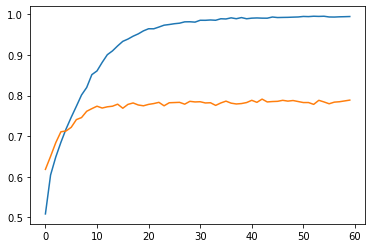

In [155]:
plt.plot(historyB.history['accuracy']) #5x5 base NEW
plt.plot(historyB.history['val_accuracy'])

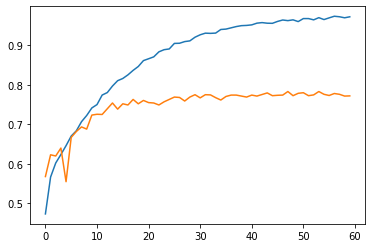

In [160]:
plt.plot(historyP.history['accuracy']) #5x5 P NEW
plt.plot(historyP.history['val_accuracy'])

In [161]:
np.max(historyP.history['val_accuracy'])

0.7829999923706055

In [156]:
np.max(historyB.history['val_accuracy'])

0.7914999723434448

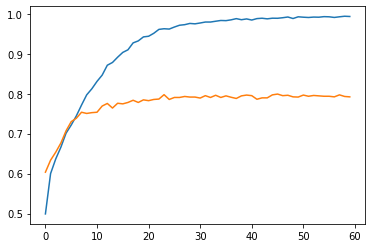

In [158]:
plt.plot(historyTB1.history['accuracy']) #5x5 base+ T NEW
plt.plot(historyTB1.history['val_accuracy'])

In [159]:
np.max(historyTB1.history['val_accuracy'])

0.7990000247955322

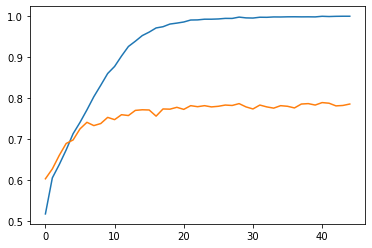

In [162]:
plt.plot(historyTB.history['accuracy']) #5x5 base+ T NEW
plt.plot(historyTB.history['val_accuracy'])

In [163]:
np.max(historyTB.history['val_accuracy'])

0.7885000109672546

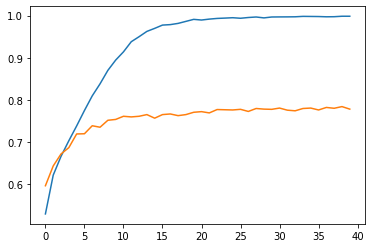

In [112]:
plt.plot(historyB.history['accuracy']) #5x5 base
plt.plot(historyB.history['val_accuracy'])

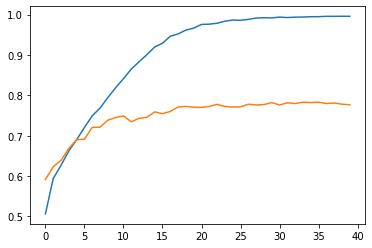

In [99]:
plt.plot(historyTB.history['accuracy']) #5x5 base+tan
plt.plot(historyTB.history['val_accuracy'])

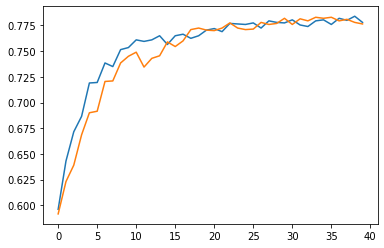

In [132]:
plt.plot(historyB.history['val_accuracy'])
plt.plot(historyTB.history['val_accuracy'])

In [131]:
np.max(historyB.history['val_accuracy'][:18])

0.7664999961853027

In [130]:
np.max(historyTB.history['val_accuracy'][:18])

0.7710000276565552

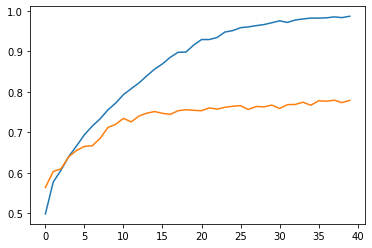

In [113]:
plt.plot(historyP.history['accuracy']) #5x5 base
plt.plot(historyP.history['val_accuracy'])

In [116]:
np.max(historyP.history['val_accuracy'])

0.7789999842643738

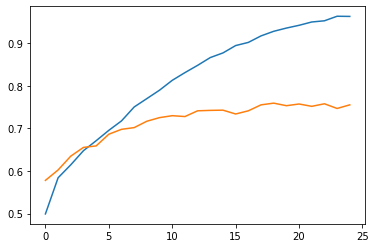

In [85]:
plt.plot(historyT.history['accuracy']) #5x5 base
plt.plot(historyT.history['val_accuracy'])

In [86]:
np.max(historyT.history['val_accuracy'])

0.7595000267028809

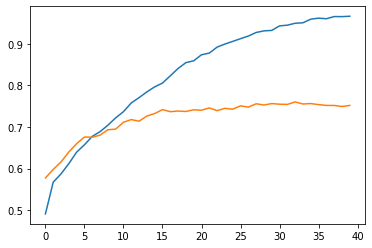

In [87]:
plt.plot(historyTG.history['accuracy']) #5x5 base
plt.plot(historyTG.history['val_accuracy'])

In [88]:
np.max(historyTG.history['val_accuracy'])

0.7605000138282776

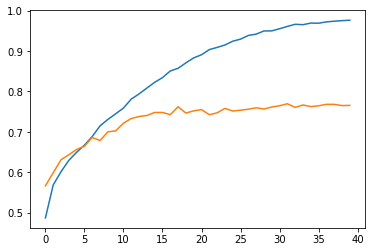

In [89]:
plt.plot(historyTP.history['accuracy']) #5x5 base
plt.plot(historyTP.history['val_accuracy'])

In [91]:
np.max(historyTP.history['val_accuracy'])

0.7695000171661377

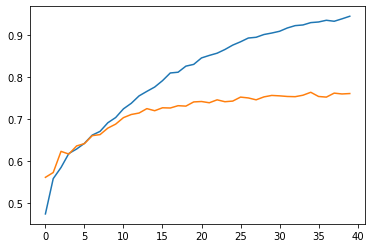

In [92]:
plt.plot(historyT5.history['accuracy']) #5x5 base
plt.plot(historyT5.history['val_accuracy'])

In [94]:
np.max(historyT5.history['val_accuracy'])

0.7639999985694885

In [117]:
np.max(historyTB.history['val_accuracy'])

0.7829999923706055

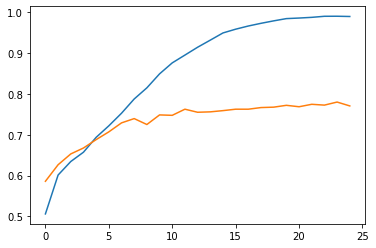

In [24]:
plt.plot(history.history['accuracy']) #5x5 base
plt.plot(history.history['val_accuracy'])

In [25]:
np.max(history.history['val_accuracy'])

0.7799999713897705

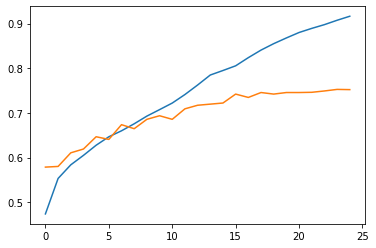

In [29]:
plt.plot(history.history['accuracy']) #5x5 base
plt.plot(history.history['val_accuracy'])

In [30]:
np.max(history.history['val_accuracy'])

0.7524999976158142

In [72]:
start_time = time.clock()
history0 = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)
print ("{:g} s".format(time.clock() - start_time))

/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


188.97 s


/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


In [85]:
start_time = time.clock()
history2 = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)
print ("{:g} s".format(time.clock() - start_time))

/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


257.546 s


/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


In [101]:
start_time = time.clock()
history3 = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)
print ("{:g} s".format(time.clock() - start_time))

/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


329.622 s


/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


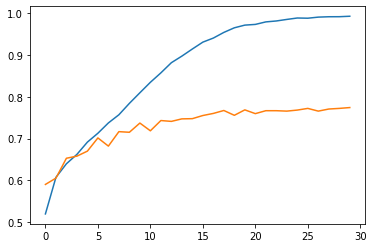

In [75]:
plt.plot(history1.history['accuracy']) #BASE 0.1drop
plt.plot(history1.history['val_accuracy'])

In [106]:
np.max(history1.history['val_accuracy'])

0.7739999890327454

In [97]:
np.max(history1.history['val_accuracy'][:15])

0.7475000023841858

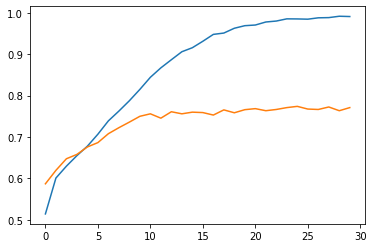

In [86]:
plt.plot(history2.history['accuracy']) #Base + poli 0.1drop
plt.plot(history2.history['val_accuracy'])

In [105]:
np.max(history2.history['val_accuracy'])

0.7739999890327454

In [96]:
np.max(history2.history['val_accuracy'][:15])

0.7609999775886536

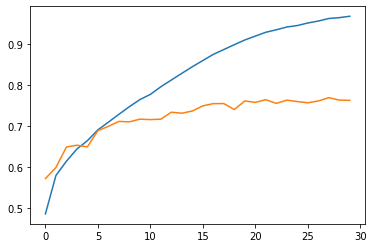

In [103]:
plt.plot(history3.history['accuracy']) #Poli + gabor 0.1 drop
plt.plot(history3.history['val_accuracy'])

In [104]:
np.max(history3.history['val_accuracy'])

0.7689999938011169

In [107]:
np.max(history3.history['val_accuracy'][:15])

0.7365000247955322

In [110]:
start_time = time.clock()
history0 = model.fit(
    train_images, train_labels,  # Base 0.3 drop
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)
print ("{:g} s".format(time.clock() - start_time))

/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


304.888 s


/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


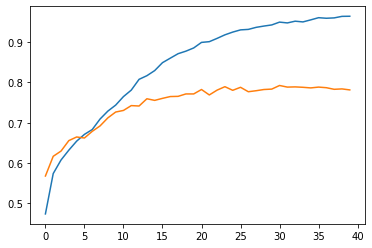

In [111]:
plt.plot(history0.history['accuracy']) #base+0.3 drop
plt.plot(history0.history['val_accuracy'])

In [123]:
np.max(history0.history['val_accuracy'])

0.7925000190734863

In [130]:
np.max(history0.history['val_accuracy'][:25])

0.7894999980926514

In [117]:
start_time = time.clock()
history01 = model.fit(
    train_images, train_labels,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)
print ("{:g} s".format(time.clock() - start_time))

/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


393.539 s


/home/anton/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


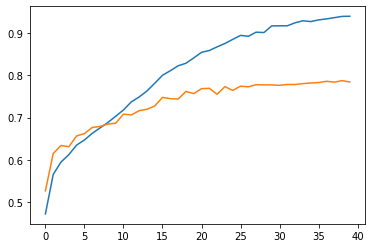

In [118]:
plt.plot(history01.history['accuracy']) #base+poli 0.3 drop
plt.plot(history01.history['val_accuracy'])

In [119]:
np.max(history01.history['val_accuracy'])

0.7870000004768372

In [131]:
np.max(history01.history['val_accuracy'][:25])

0.7730000019073486

In [89]:
w = model.weights[0]

In [11]:
p = Poli3d(3,3,1,64,tf.nn.relu)

In [93]:
p.cofs = w

In [113]:
import plotly.graph_objects as go
import random
import numpy as np

i, j = random.randint(0, 3), random.randint(0, 7)

# Generate nicely looking random 3D-field
X, Y, Z = np.mgrid[-1:1,-1:1,-1:1] # be careful with meshgrid
#vol = kernel.init_kernel()[j, i].cpu().detach().numpy()
vol = np.array(p.poli(15))
print(vol.flatten())

fig = go.Figure(data=go.Volume(
    x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
    value=vol.flatten(),
    isomin=0.2,
    isomax=0.0,
    opacity=0.2,
    surface_count=25,
    colorscale='Picnic'
    ))

fig.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)
fig.show()

[0.05208586 0.1977976  0.7862065  0.09844945 0.26477075 0.88737345
 0.35998243 0.49621916 1.1023216  0.13127625 0.32746273 1.1052648
 0.23624393 0.45304    1.2650359  0.55134946 0.738061   1.5335566
 0.38334405 0.61484534 1.5668803  0.5686517  0.8207625  1.8069913
 0.95906556 1.1810919  2.1508205 ]


In [87]:
np.max(history3.history['val_accuracy'])

0.7294999957084656

In [84]:
a = X_train[3].reshape(16,16,16)

In [12]:
train_images = X_train.reshape(10000,16,16,16,1)
train_labels = one_hot(y_train)
val_images = X_test.reshape(2000,16,16,16,1)
val_labels = one_hot(y_test)

In [85]:
t = a>np.min(a)

In [86]:
X = np.arange(16)
Y = np.arange(16)
Z = []
for i in range(16):
    z1 = []
    for j in range(16):
         z1.append(t[i][j][10])
    Z.append(z1)
Z = np.array(Z)

In [65]:
Z1.shape


(16, 16)

In [14]:
def poli(a,x,y):
    one = np.ones(x.shape)
    v = tf.stack([x**3,y**3,x**2*y,y**2*x,x**2,y**2,x*y,x,y,one])
    v = tf.transpose(v)
    #v = tf.broadcast_to(v,[3,5,5,6])
    #print(v.shape)
    out = tf.math.reduce_sum(v*a,-1)
    return tf.reshape(out,[out.shape[0],out.shape[1],1,1])

In [11]:
def one_hot(labels):
    res = []
    for i in labels:
        a = [0]*10
        a[i] = 1
        res.append(a)
    return np.array(res)

In [374]:
b = tf.Variable([x**2,x,x,x,x])

In [136]:
x = np.array([np.arange(4)]*4)
y  = x.transpose()

In [380]:
b = tf.transpose(b)

In [137]:
a = tf.random.uniform([1,10])
poli(a,x,y).shape

TensorShape([4, 4, 1, 1])

In [7]:
a = tf.random.uniform([3,2]) 

In [8]:
class MyLayerD(tf.keras.layers.Layer):
    def __init__(self,step,kernel_size, in_ch, out_ch, func,padding = 'SAME', **kwargs):  
        super().__init__(**kwargs)
        #self.output_dim = outputdim  # The number of cells in the next layer,
        self.activatefunc = func  # Activation function
        self.step = step
        self.kernel_size = kernel_size
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.padding = padding
        self.x = np.array([np.arange(kernel_size)]*kernel_size)
        self.y = self.x.transpose()
        
    def poli(self,num):
        one = tf.ones(self.x.shape)
        v = tf.stack([self.x**2,self.y**2,self.x*self.y,self.x,self.y,one])
        v = tf.transpose(v)
        out = tf.math.reduce_sum(v*self.cofs[:,num:num+1,:],-1)
        return tf.reshape(out,[out.shape[0],out.shape[1],1,1])
        
    def build(self, input_shapes): 
        self.cofs = self.add_weight(name='weights', shape=(( self.in_ch, self.out_ch,6)), initializer='uniform', trainable=True)
        
    def call(self, inputdata):
        kernel = self.poli(0)
        for i in range(self.out_ch-1):
            kernel = tf.concat([kernel,self.poli(i+1)],3)
        outs = tf.nn.conv2d(inputdata, kernel, strides=[1, 1, 1, 1], padding=self.padding)  
        output = self.activatefunc(outs)
        return output

In [232]:
class MyLayerD2(tf.keras.layers.Layer):
    def __init__(self,step,kernel_size, in_ch, out_ch, func,padding = 'SAME', **kwargs):  
        super().__init__(**kwargs)
        #self.output_dim = outputdim  # The number of cells in the next layer,
        self.activatefunc = func  # Activation function
        self.step = step
        self.kernel_size = kernel_size
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.padding = padding
        self.x = np.array([np.arange(kernel_size)-(kernel_size-1)/2]*kernel_size)
        #self.x = np.array([np.arange(kernel_size)]*kernel_size)
        self.y = self.x.transpose()
        one = tf.ones(self.x.shape)
        self.v = tf.transpose(tf.stack([self.x**3,self.y**3,self.x**2*self.y,self.y**2*self.x,self.x**2,self.y**2,self.x*self.y,self.x,self.y,one]))
        
    def poli(self,num):
        out = tf.math.reduce_sum(self.v*self.cofs[:,num:num+1,:],-1)
        return tf.reshape(out,[out.shape[0],out.shape[1],1,1])
        
    def build(self, input_shapes): 
        self.cofs = self.add_weight(name='weights', shape=(( self.in_ch, self.out_ch,10)), initializer='uniform', trainable=True)
        
    def call(self, inputdata):
        kernel = self.poli(0)
        for i in range(self.out_ch-1):
            kernel = tf.concat([kernel,self.poli(i+1)],3)
        outs = tf.nn.conv2d(inputdata, kernel, strides=[1, 1, 1, 1], padding=self.padding)  
        output = self.activatefunc(outs)
        return output

In [648]:
#tf.concat([tf.random.uniform([5,5,1,1]),tf.random.uniform([5,5,1,1])],3)

In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [90]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [91]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [92]:
train_images = train_images.reshape(60000,28,28,1) / 255.0
test_images = test_images.reshape(10000,28,28,1) / 255.0

In [94]:
train_labels1 = one_hot(train_labels)
test_labels1 = one_hot(test_labels)

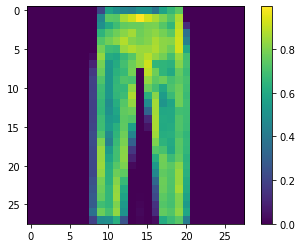

In [95]:
plt.figure()
plt.imshow(train_images[16])
plt.colorbar()
plt.grid(False)

In [107]:
m = MyLayerD2(2,5,1,64,tf.nn.relu)

In [109]:
m.y

array([[-2., -2., -2., -2., -2.],
       [-1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.]])

In [120]:
inp = Input((28,28,1))
#out1 = MyLayerD(2,5,1,8, tf.nn.relu)(inp)
out1 = tf.keras.layers.Conv2D(64,(4,4),padding="same", activation = "relu")(inp)
#out2 = tf.keras.layers.Conv2D(32,(5,5),padding="valid", activation = "relu")(out1)
out3 = MaxPooling2D(pool_size=(2, 2))(out1)
out4 = tf.keras.layers.Conv2D(64,(4,4),padding="same", activation = "relu")(out3)
#out5 = tf.keras.layers.Conv2D(64,(3,3),padding="valid", activation = "relu")(out4)
#out2 = tf.keras.layers.Conv2D(32,(5,5),padding="valid", activation = "relu")(out1)
out31 = MaxPooling2D(pool_size=(2, 2))(out4)
#out41 = tf.keras.layers.Conv2D(64,(3,3),padding="same", activation = "relu")(out6)
#out51 = tf.keras.layers.Conv2D(128,(3,3),padding="same", activation = "relu")(out41)
#out61 = MaxPooling2D(pool_size=(2, 2))(out51)
out7 = Flatten()(out31)
out8 = Dense(256,activation = 'relu')(out7)
out9 = Dense(64, activation = 'relu')(out8)
out10 = Dense(10,activation = "softmax")(out9)
#outf = F(out)
model = Model(inputs = inp, outputs = out10)

In [154]:
inp = Input((28,28,1))
#out1 = MyLayerD(2,5,1,8, tf.nn.relu)(inp)
out1 = MyLayerD2(2,4,1,64, tf.nn.relu)(inp)
#out2 = tf.keras.layers.Conv2D(32,(5,5),padding="valid", activation = "relu")(out1)
out3 = MaxPooling2D(pool_size=(2, 2))(out1)
out4 = tf.keras.layers.Conv2D(64,(4,4),padding="same", activation = "relu")(out3)
#out5 = tf.keras.layers.Conv2D(64,(3,3),padding="valid", activation = "relu")(out4)
#out2 = tf.keras.layers.Conv2D(32,(5,5),padding="valid", activation = "relu")(out1)
out31 = MaxPooling2D(pool_size=(2, 2))(out4)
#out41 = tf.keras.layers.Conv2D(64,(3,3),padding="same", activation = "relu")(out6)
#out51 = tf.keras.layers.Conv2D(128,(3,3),padding="same", activation = "relu")(out41)
#out61 = MaxPooling2D(pool_size=(2, 2))(out51)
out7 = Flatten()(out31)
out8 = Dense(256,activation = 'relu')(out7)
out9 = Dense(64, activation = 'relu')(out8)
out10 = Dense(10,activation = "softmax")(out9)
#outf = F(out)
model = Model(inputs = inp, outputs = out10)

In [121]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        65600     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8030

In [137]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
my_layer_d2_5 (MyLayerD2)    (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        65600     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               8030

In [155]:
INIT_LR = 0.005
BATCH_SIZE = 64
EPOCHS = 15

model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  
    metrics=['accuracy']  
)
def lr_scheduler(epoch):
    return INIT_LR * 0.94** epoch


In [156]:
history2 = model.fit(
    train_images, train_labels1,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_images, test_labels1),
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
    shuffle=True,
    verbose=0,
)

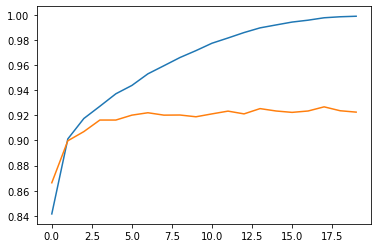

In [125]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [126]:
np.max(history.history['val_accuracy'])

0.9266999959945679

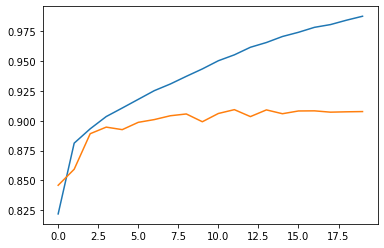

In [133]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

In [134]:
np.max(history1.history['val_accuracy'])

0.9092000126838684

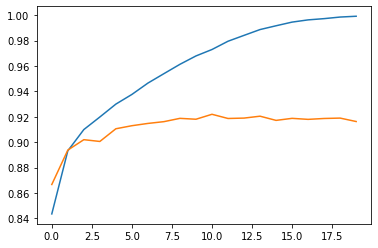

In [140]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

In [141]:
np.max(history2.history['val_accuracy'])

0.921999990940094

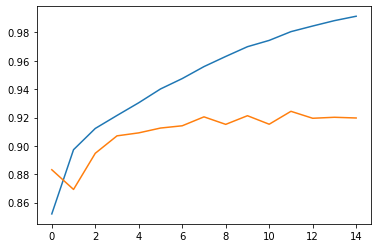

In [157]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

In [159]:
np.max(history2.history['val_accuracy'])

0.9243999719619751